Title: Working with and Visualizing Geospatial Data

Author: Sean Reid

Date: 07/07/2022

# Outline

This workshop focuses on working with geospatial data in the following ways:

* Types of data and appropriateness for your application - Point, Line, and Polygon
* Datums and projections - What to do when things go wrong......
* Trusting your data
* Modifial areal unit problem
* Thinking like a geographer

We covered the details of each of these things during the presentation but now we can apply them in practice. We will run through some spatial analysis techniques you can use to investigate the spatial nature of your data. We will cover:
* Moran's I
* Geographically Weighted Regression (GWR)
* Maybe look at an ABM (not a good one) example
* Maybe a fun 3D map!

## Types of Data

Understanding the types of spatial data you have is important because each type is unique in how it represents things in the real world. The Open Geospatial Consortium is the gold standard for digital representation of spatial data and most every application uses their standards. [Click here](https://portal.ogc.org/files/?artifact_id=25355) to view the standards for the simple features we are going to talk about today. There are also set standards for spatial processes like distance, buffers, intersections, etc. I like the PostGIS documentation for the data types and spatial processes as well. Use this [link](https://postgis.net/docs/manual-3.2/) if you care to read more about it.

Let's start by loading in some example spatial data. We will use some example spatial data from Pysal. Pysal is a great Python library for spatial data analysis. We will use it for both the Moran's I and GWR.

In [1]:
## Load the necessary modules
import os, pandas as pd, geopandas as gpd, numpy as np
from libpysal import examples
import libpysal as ps
import matplotlib.pyplot as plt


In [2]:
## Load the two datasets we are going to use for this workshop

## MSM US county level dataset
msm = gpd.read_file(r"data\msm_data.shp")

## Quick data cleaning to ensure things run smoothly
msm['same_sex_m'] = msm['same_sex_m'].astype('float')
msm['total_hh'] = msm['total_hh'].astype('float')
msm = msm.rename(columns={"index":"msm_index"})

## Berlin Dataset
ber = gpd.read_file(ps.examples.get_path("prenzlauer.zip"))

The MSM US dataset consists of all US counties derived from 2018 ACS 5 year data. It has information on number of same sex male households by county, voting history, population, urbanicity, income, and LGBTQ community index.

The Berlin dataset consists of Airbnb rental properties in the Prenzlauer Berg area of the city. The dataset contains information on how many people it can host, review scores, bedrooms, bathrooms, and price per night. This dataset also has X and Y coordinates which will come in handy later.

Let's plot the data using geopandas mapping functionality to see what our data looks like.

<AxesSubplot:>

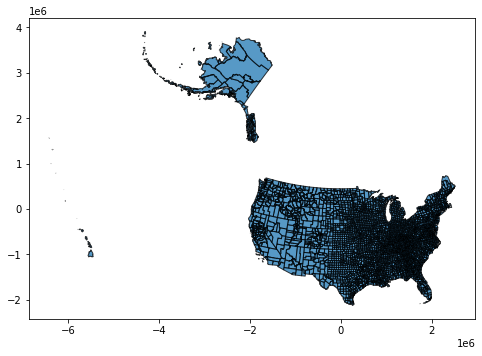

In [3]:
## Map the MSM data
msm.plot(figsize=(8,8), alpha=0.75, edgecolor='black')

<AxesSubplot:>

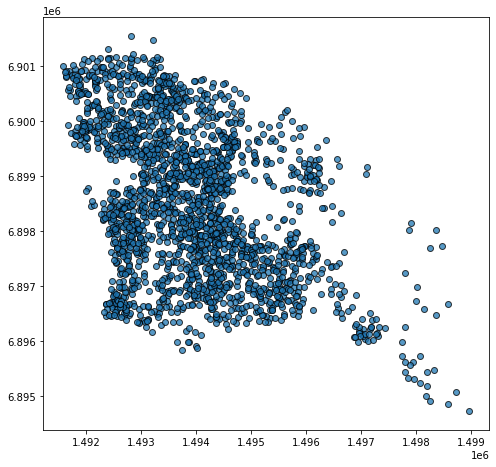

In [4]:
## Map the Berlin Data
ber.plot(figsize=(8,8), alpha=0.75, edgecolor='black')

Awesome, we can see that our MSM data is a polygon dataset and our Berlin dataset is a point dataset. This will influence how we think about the data moving forward and what we can do with it. These plots are a nice start but they don't give much context about what is around it. So let's add a basemap to give some context!

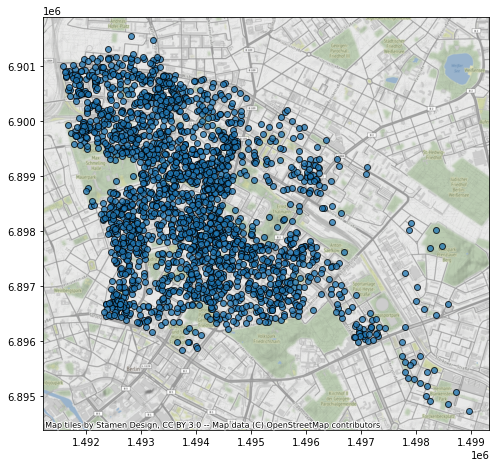

In [5]:
## Add a basemap to the maps above
## Import the module contextily which is commonly used in these situations
import contextily as cx

## Plot the Berlin data but with a basemap this time
ax = ber.plot(figsize=(8,8), alpha=0.75, edgecolor='black')
cx.add_basemap(ax)

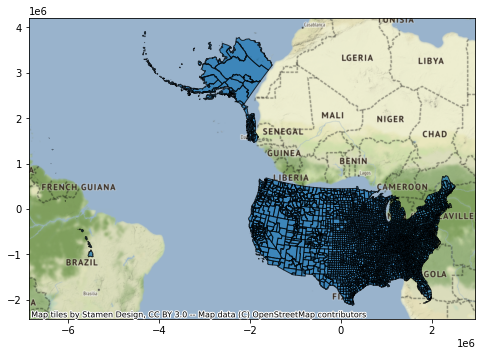

In [6]:
## Plot the MSM data but with a basemap this time
ax = msm.plot(figsize=(8,8), alpha=0.75, edgecolor='black')
cx.add_basemap(ax)

### Projection Issues

The Berlin data looks great on the basemap but what in the world is going on with the MSM US data????? Let's check the Coordinate reference systems for both to see what's going on.......

In [7]:
## Check CRS for each Georgia and Berlin
print(msm.crs)
print(ber.crs)

epsg:2163
epsg:3857


Ahhhhhh okay this makes more sense now. The MSM data is in the wrong reference system, so it just got plopped in the wrong place on the basemap. The Berlin data is in a Web Mercator projection, which is consistent with the basemap. You might think to yourself "let's use a WGS 84 projection" but that uses different units than Web Mercator. So to ensure the msm data lines up with the basemap, we will assign it to EPSG 3857.

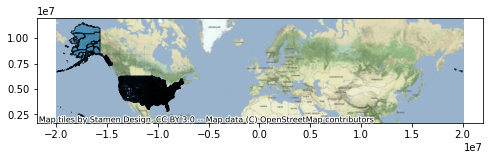

In [8]:
msm = msm.to_crs(epsg=3857)

# Plot the Georgia data but with a basemap this time
ax1 = msm.plot(figsize=(8,8), alpha=0.75, edgecolor='black')
cx.add_basemap(ax1)

Okay, that looks better and we have things lined up. Sometimes this doesn't work so nicely when the data doesn't have a CRS or projection to start with. I tried setting this tutorial up using a different Pysal dataset and I couldn't figure out how to correct the coordinate system. It can be frustrating when the spatial information for a dataset is whack...... Data quality is important. It could also have been operator error on not being able to fix the projection but who knows.......

## Moran's I
Now we are going going to look at the spatial structure of our data by running global and local Moran's I calculations. These tests will tell us if there is significant clustering in our dependent variables. In the case of our two examples they are price per night and same sex male households for the Berlin Airbnb and MSM data respectively.

First we need to generate a spatial weights matrix which will be done using Pysal

In [9]:
## Import the modules necessary for this task
from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from splot.esda import lisa_cluster

## Set the spatial weights matrix for the msm dataset
y_msm = msm['same_sex_m']
w_msm = Queen.from_dataframe(msm)

## This is row standardizing the weights matrix so everything sums to 1
w_msm.transform = 'r'

## Set the spatial weights for the Berlin dataset
y_ber = ber['price']
w_ber = Queen.from_dataframe(ber)

## This is row standardizing the weights matrix so everything sums to 1
w_ber.transform = 'r'

C:\Users\Sean Reid\anaconda3\envs\geo_workshop\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 8 islands with ids: 1526, 1990, 1991, 1992, 1993, 2985, 2988, 3128.
  warnings.warn(message)


('WARNING: ', 1526, ' is an island (no neighbors)')
('WARNING: ', 1990, ' is an island (no neighbors)')
('WARNING: ', 1991, ' is an island (no neighbors)')
('WARNING: ', 1992, ' is an island (no neighbors)')
('WARNING: ', 1993, ' is an island (no neighbors)')
('WARNING: ', 2985, ' is an island (no neighbors)')
('WARNING: ', 2988, ' is an island (no neighbors)')
('WARNING: ', 3128, ' is an island (no neighbors)')


As you can see above, we have some islands which will cause issues for some local clustering we want to do later. We can simply remove the islands from our dataset or we can convert our polygon data into point data and create a spatial weights matrix that way. It's a sly solution but can introduce it's own unique problems. Let's take a look at this a bit later!

Moran's I value is: 0.2562847366165525
P value is: 0.001


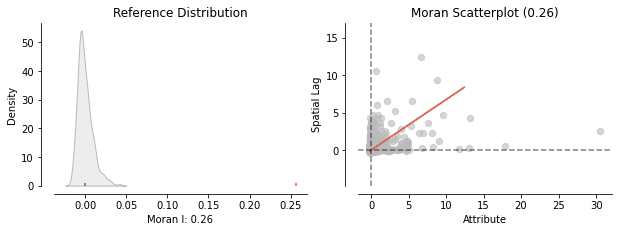

In [10]:
## Now we will calculate the Global Moran's I for each dataset

## Generate Global Moran's I for MSM dataset

## Calculate Moran's I
moran_msm = Moran(y_msm,w_msm)

## Print moran's I value and p value
print("Moran's I value is:",moran_msm.I)
print("P value is:",moran_msm.p_sim)
plot_moran(moran_msm, zstandard=True, figsize=(10,3))
plt.show()

Moran's I value is: 0.062363675915320736
P value is: 0.001


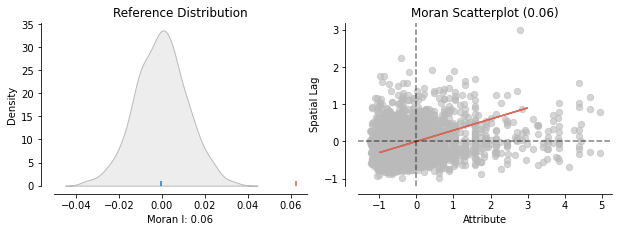

In [11]:
## Generate Global Moran's I for Berlin Airbnb dataset

## Calculate Moran's I
moran_ber = Moran(y_ber,w_ber)

## Print moran's I value and p value
print("Moran's I value is:",moran_ber.I)
print("P value is:",moran_ber.p_sim)
plot_moran(moran_ber, zstandard=True, figsize=(10,3))
plt.show()

In [12]:
## We some evidence of spatial autocorrelation in our data so we want to take a look at our local Moran's I and create LISA (Local Inidicator of Spatial Autocorrelation).


## Import necessary modules
from esda.moran import Moran_Local

## Generate Local Moran's I and LISA Clusters for each dataset

## Local Moran's I for MSM dataset
moran_loc_msm = Moran_Local(y_msm,w_msm)
fig, ax = moran_scatterplot(moran_loc_msm, p=0.05)
plt.show()


## When this code throws an error, DON'T PANIC. It's supposed to happen. Scroll down and read the message underneath.

ValueError: cannot assign slice from input of different size

The error above occured because we have islands in our data and that is causing the code to stall. Removing islands is a perfectly reasonable thing to do here but I want to take a moment to show you why data type is important and how it can help you solve some problems if you know how to visually inspect your data.

First I am going to show you the connections between counties generated by the polygon derived weights matrix. Then we are going to generate another weights matrix from centroids of polygons and use that to calculate the local moran's I for counties.

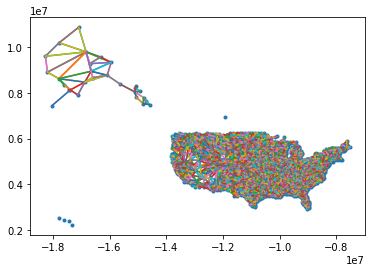

In [14]:
## Let's take a look at the spatial representation of our weights matrix

## Create a centroid in our dataset for visualization purposes (and we will need it later)
msm['centroid'] = msm.centroid

## Generate an numpy array of the centroids
centroids = np.array([list((i.x,i.y)) for i in msm['centroid']])

## Split the x and y coordinates into separate lists
xpoints = []
ypoints = []
for i in msm['centroid']:
    xpoints.append(i.x)
    ypoints.append(i.y)
    
## Make the connections between points
plt.plot(centroids[:,0], centroids[:,1],'.')
for k,neighs in w_msm.neighbors.items():
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment[:,0], segment[:,1], '-')
plt.show()

Above we can see the islands that are causing us issues but the connections between counties look about right! It's a bit of a mess but it looks okay.

Let's see what this would look like if we used points instead of polygons to create our spatial weights matrix.

In [15]:
## Set the geometry from the polygons to the points
msm = msm.set_geometry('centroid')

## Recreate the weights

## Set the spatial weights matrix for the msm dataset
y_msm = msm['same_sex_m']
w_msm = Queen.from_dataframe(msm)

## This is row standardizing the weights matrix so everything sums to 1
w_msm.transform = 'r'

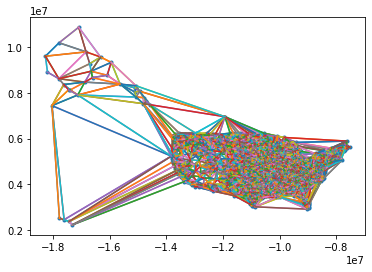

In [17]:
## Now let's see how things look by mapping the connections again

## Generate an numpy array of the centroids
centroids = np.array([list((i.x,i.y)) for i in msm['centroid']])

## Split the x and y coordinates into separate lists
xpoints = []
ypoints = []
for i in msm['centroid']:
    xpoints.append(i.x)
    ypoints.append(i.y)
    
## Make the connections between points
plt.plot(centroids[:,0], centroids[:,1],'.')
for k,neighs in w_msm.neighbors.items():
    origin = centroids[k]
    for neigh in neighs:
        segment = centroids[[k,neigh]]
        plt.plot(segment[:,0], segment[:,1], '-')
plt.show()

Looks similar but now we have some really weird connections between places that should not be connected. Hawaii and Alaska are connected to the contiguous US and probably shouldn't be. You can tinker with the parameters here and make a judgement call based on your unique situation but it's important to consider the type of spatial data you are using and how it's influencing your results.

I'm not super stoked on this matrix but it won't break my code so let's use it for now!

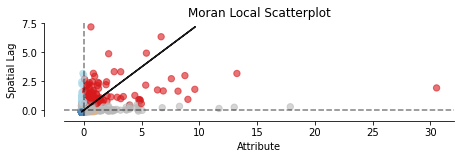

In [18]:
## Local Moran's I for MSM dataset
moran_loc_msm = Moran_Local(y_msm,w_msm)
fig, ax = moran_scatterplot(moran_loc_msm, p=0.05)
plt.show()

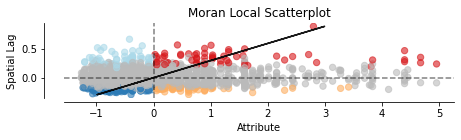

In [19]:
## Local Moran's I for Berlin Airbnb dataset
moran_loc_ber = Moran_Local(y_ber,w_ber)
fig, ax = moran_scatterplot(moran_loc_ber, p=0.05)
plt.show()

Okay, now we have a local moran scatter plot for each data set with the values that are significant highlighted in 4 colors. 
* Red = High values clustered near other high values
* Orange = High values clustered near low values
* Light Blue = Low values clustered near high values
* Dark Blue = Low values clustered near low values

We can also map this using a LISA cluster rather than looking at it on a plot!

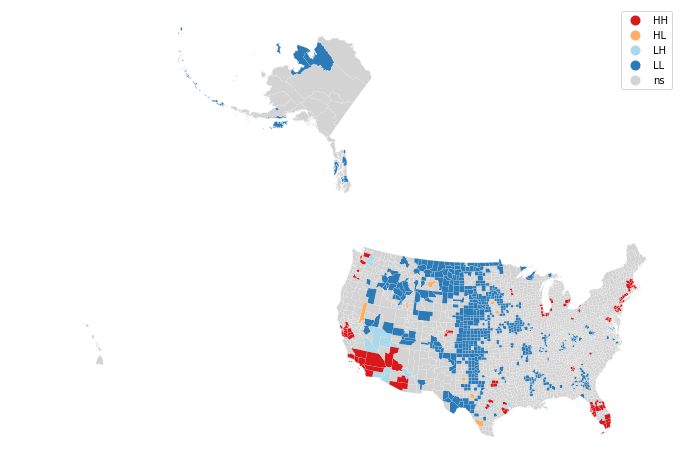

In [20]:
## Create a LISA cluster for each dataset

## LISA for MSM data
## Set geometry back to polygons
msm = msm.set_geometry('geometry')
msm = msm.to_crs(epsg=2163)
fig,ax = lisa_cluster(moran_loc_msm,msm,p=0.05,figsize=(12,12))

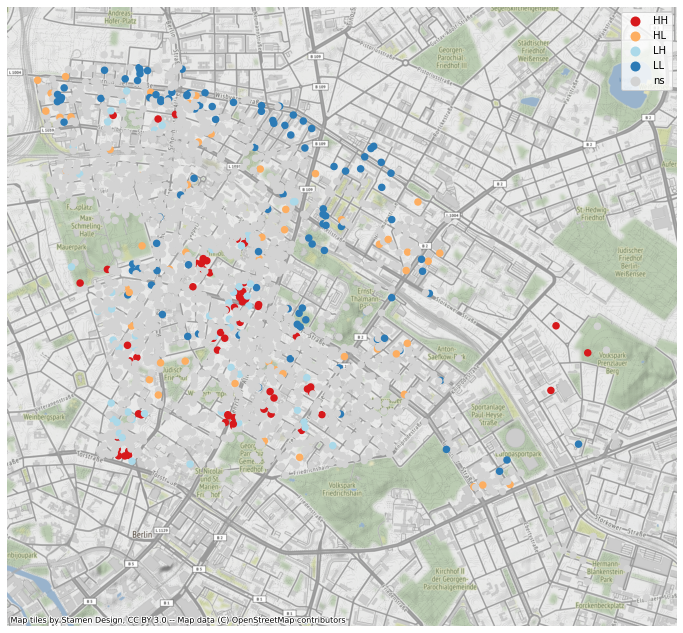

In [21]:
## LISA for Berlin Airbnb Data
fix,ax = lisa_cluster(moran_loc_ber,ber,p=0.05,figsize=(12,12))
cx.add_basemap(ax)

### Geographically Weighted Regression (GWR)

Finally, we are going to run a geographically weighted regression model on our two datasets. This model assumes that there are non-stationary relationships in the data where the relationship between the independent and dependent variables changes based on location.

This type of analysis allows researchers to test Tobler's first law of geography in real world settings. Like we talked about during the presentation; space can be thought of in ever changing ways as technology and innovation continue to push the boundaries of geographic analysis.

In [22]:
## Import necessary modules for GWR
from pysal.model import mgwr
import patsy

In [24]:
## Generate our standardized dataset for GWR Model

## Equation for MSM dataset
y_msm,X_msm = patsy.dmatrices('''standardize(same_sex_m) ~ standardize(over_18_me) + standardize(total_hh) + standardize(median_inc) + standardize(pvi)''', data=msm)

## Equation for Berlin Dataset
y_ber,X_ber = patsy.dmatrices('''standardize(price) ~ standardize(accommodat) + standardize(review_sco) + standardize(bedrooms) + standardize(bathrooms) + standardize(beds)''', data=ber)

In [25]:
## set coordinates for the next section

## MSM Data
coords_msm = np.column_stack([msm['centroid'].to_crs(epsg=3857).x,msm['centroid'].to_crs(epsg=3857).y])

## Berlin Airbnb Data
ber['centroid'] = ber.centroid
coords_ber = np.column_stack([ber['centroid'].to_crs(epsg=3857).x,ber['centroid'].to_crs(epsg=3857).y])

In [26]:
## set the bandwidth parameter
import warnings

## Set bandwidth for MSM data
warnings.filterwarnings('ignore')
bw_msm = mgwr.sel_bw.Sel_BW(coords_msm,np.asarray(y_msm),np.asarray(X_msm),fixed=False,spherical=True)
bw_msm.search()

## Set bandwidth for Berlin Airbnb Data
bw_ber = mgwr.sel_bw.Sel_BW(coords_ber,np.asarray(y_ber),np.asarray(X_ber),fixed=False,spherical=True)
bw_ber.search()

159.0

In [27]:
## Initialize and fit the model for each dataset

## MSM Data
gwr_model_msm = mgwr.gwr.GWR(coords_msm,np.asarray(y_msm),np.asarray(X_msm),bw_msm.bw[0])

results_msm = gwr_model_msm.fit()

results_msm.summary()


Model type                                                         Gaussian
Number of observations:                                                3141
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            273.967
Log-likelihood:                                                    -625.985
AIC:                                                               1261.970
AICc:                                                              1263.997
BIC:                                                             -24978.034
R2:                                                                   0.913
Adj. R2:                                                              0.913

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [28]:
## Berlin Airbnb Data
gwr_model_ber = mgwr.gwr.GWR(coords_ber,np.asarray(y_ber),np.asarray(X_ber),bw_ber.bw[0])

results_ber = gwr_model_ber.fit()

results_ber.summary()

Model type                                                         Gaussian
Number of observations:                                                2203
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1303.820
Log-likelihood:                                                   -2548.161
AIC:                                                               5108.321
AICc:                                                              5110.372
BIC:                                                             -15607.753
R2:                                                                   0.408
Adj. R2:                                                              0.407

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

These outputs are interesting but can be quite difficult to interpret. We are generally interested in the spread coefficient estimates. They can be plotted or put into a table but since we are interested in spatial relationships, we are going to map it!

In [29]:
## Filter our estimates for significance

## MSM Data
filtered_estimates_msm = results_msm.filter_tvals(alpha=.05)

## Berlin Airbnb Data
filtered_estimates_ber = results_ber.filter_tvals(alpha=.05)

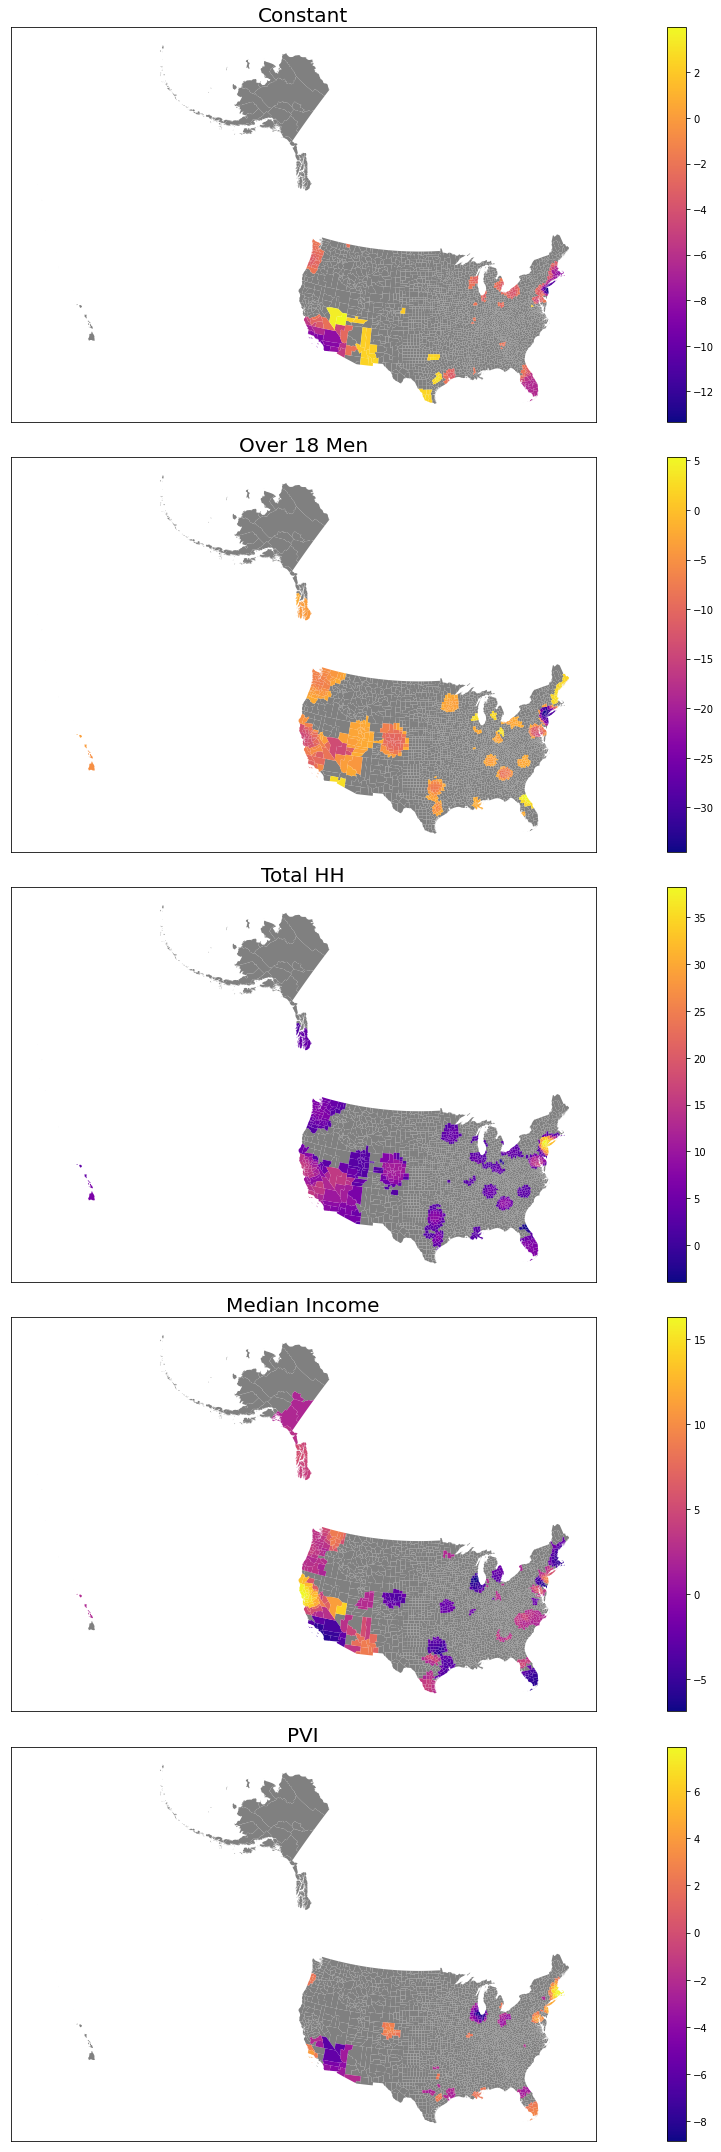

In [30]:
## Let's plot these significance values in a map

## MSM Data
f,ax = plt.subplots(5,1,figsize=(20,30),subplot_kw=dict(aspect='equal'))
ax = ax.flatten()

## first we are going to work with each of the covariates
for i,row in enumerate(filtered_estimates_msm.T):
    ## make a new column in the data dataframe
    data_tmp = msm.assign(toplot = filtered_estimates_msm.T[i])
    
#     data_tmp = data_tmp[~data_tmp['state_x'].isin(['02','15'])]
    
    ## now we want to plot all non significant values in light gray
    data_tmp.query('toplot == 0').sort_values('toplot').plot(color='grey', marker='.', ax=ax[i])
    
    ## plot all the significant estimates in color
    data_tmp.query('toplot != 0').sort_values('toplot').plot('toplot',cmap='plasma',marker='.', ax=ax[i],legend=True)
    

    ax[i].set_title(['Constant','Over 18 Men','Total HH','Median Income','PVI'][i],fontsize=20)
    
    ## Remove lat and lon ticks and labels
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
f.tight_layout()
plt.show()

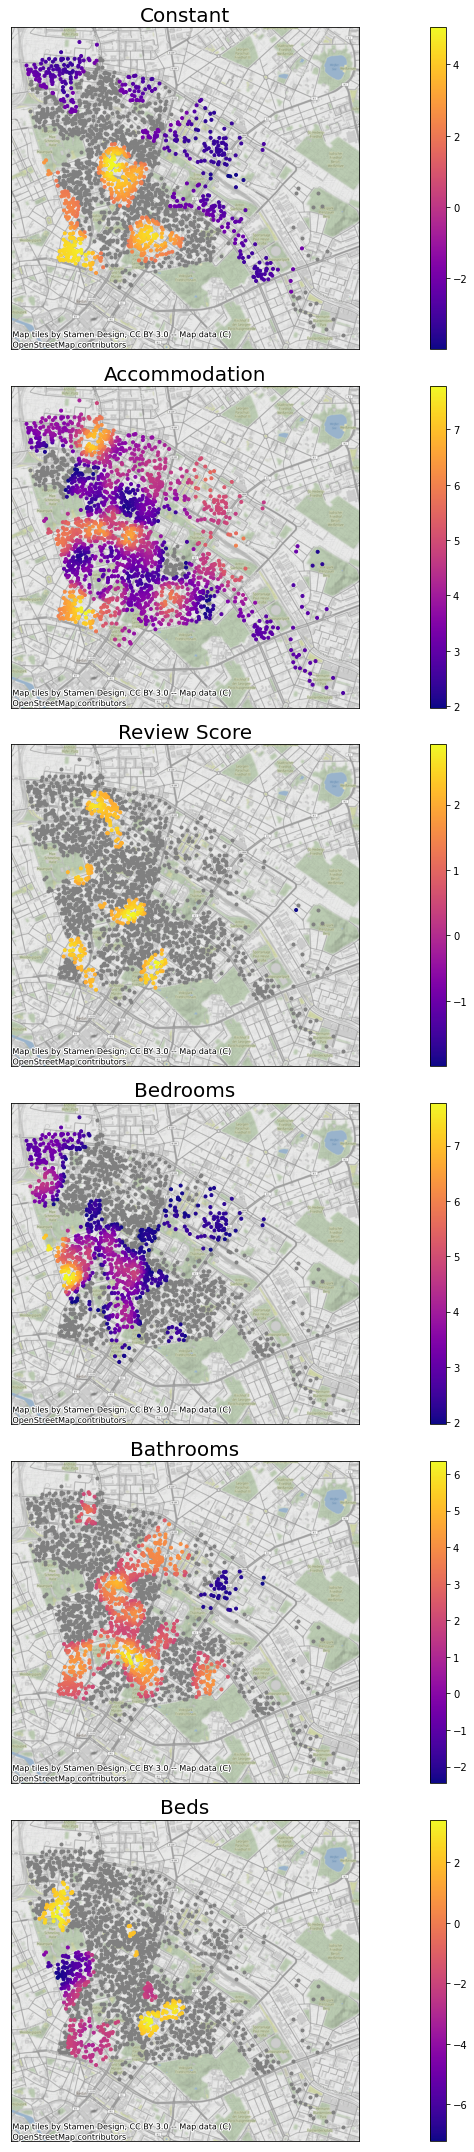

In [31]:
## Berlin Airbnb Data
f,ax = plt.subplots(6,1,figsize=(20,30),subplot_kw=dict(aspect='equal'))
ax = ax.flatten()

## first we are going to work with each of the covariates
for i,row in enumerate(filtered_estimates_ber.T):
    ## make a new column in the data dataframe
    data_tmp = ber.assign(toplot = filtered_estimates_ber.T[i])
    
    
    ## now we want to plot all non significant values in light gray
    data_tmp.query('toplot == 0').sort_values('toplot').plot(color='grey', marker='.', ax=ax[i])
    
    ## plot all the significant estimates in color
    data_tmp.query('toplot != 0').sort_values('toplot').plot('toplot',cmap='plasma',marker='.', ax=ax[i],legend=True)
    
    
    ax[i].set_title(['Constant','Accommodation','Review Score','Bedrooms','Bathrooms',
                    'Beds'][i],fontsize=20)
    
    ## Remove lat and lon ticks and labels
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    cx.add_basemap(ax[i])
    
f.tight_layout()
plt.show()

In both datasets we see spatially varying relationships where some covariates are positively associated with the dependent variables and are negatively associated in others. These examples are simplistic and need much more formal framing/background knowledge for this type of analysis to be useful. Going through the exercise and seeing the possibilities are worth seeing I think.

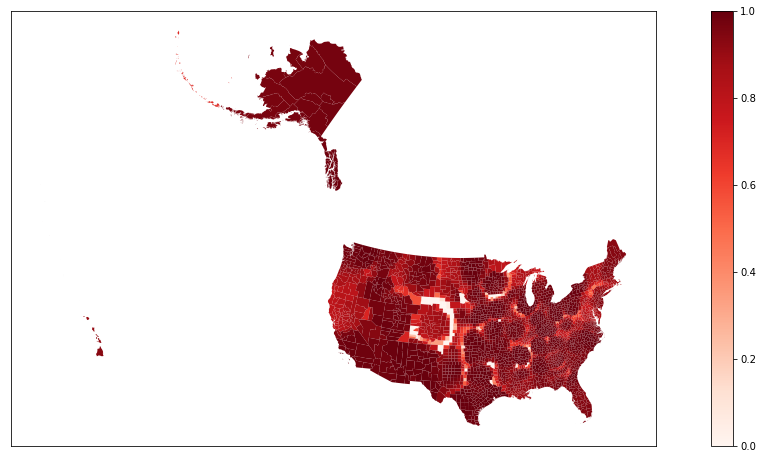

In [32]:
## Finally we can plot the R2 for each point/polygon in the regression model

## MSM Data
fig, ax = plt.subplots(1,figsize=(20,8))
ax = msm.assign(r2=results_msm.localR2).sort_values('r2').plot('r2',ax=ax,legend=True,marker='.',vmin=0,vmax=1,cmap='Reds')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.show()

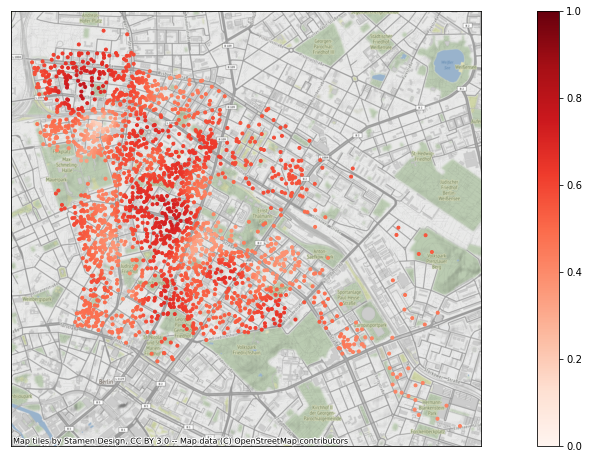

In [33]:
## Berlin Airbnb Data
fig, ax = plt.subplots(1,figsize=(20,8))
ax = ber.assign(r2=results_ber.localR2).sort_values('r2').plot('r2',ax=ax,legend=True,marker='.',vmin=0,vmax=1,cmap='Reds')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax)
plt.show()